In [1]:
import os
import torch
import pyprobound
import pyprobound.plotting

# Data specification

In [2]:
alphabet = pyprobound.alphabets.DNA()
dataframe = pyprobound.get_dataframe(
    ["../data/CTCF_ChIP-exo5/noAb_CTCF.center.1000000.tsv.gz"]
)
count_table = pyprobound.CountTable(dataframe, alphabet, zero_pad=True)

# Model specification

In [3]:
nonspecific = pyprobound.layers.NonSpecific(alphabet=alphabet, name="NS")
ctcf_psam = pyprobound.layers.PSAM(
    alphabet=alphabet,
    kernel_size=18,
    seed=["---CGCCMYCTAGTGG--"],
    name="CTCF",
)

In [4]:
# NS
conv0d = pyprobound.layers.Conv0d.from_nonspecific(nonspecific, count_table)
mode_ns = pyprobound.Mode([conv0d])

# CTCF
conv1d = pyprobound.layers.Conv1d.from_psam(
    ctcf_psam,
    count_table,
    train_posbias=True,
    bias_bin=5,
    length_specific_bias=False,
    bias_mode="same",
)
mode_ctcf = pyprobound.Mode([conv1d])

In [5]:
order = [[mode_ns.key()], [mode_ctcf.key()]]
round_0 = pyprobound.rounds.InitialRound()
round_1 = pyprobound.rounds.BoundUnsaturatedRound.from_binding(
    [mode_ns, mode_ctcf], round_0, activity_heuristic=0.1
)
experiment = pyprobound.Experiment(
    [round_0, round_1],
    counts_per_round=count_table.counts_per_round,
)
model = pyprobound.MultiExperimentLoss([experiment], full_loss=True)

# Fitting

In [6]:
optimizer = pyprobound.Optimizer(
    model,
    [count_table],
    greedy_threshold=0,
    device="cpu",
    optim_args={"max_iter": 500},
    checkpoint="CTCF_ChIP-exo5_center.pt",
    output="CTCF_ChIP-exo5_center.txt",
)

In [7]:
print(optimizer.get_train_sequential(order=order))

### Binding: NSNonSpecific
	Step 0
		MultiExperimentLoss.freeze()
		0thExperiment→1stBoundUnsaturatedRound→Aggregate.activity_heuristic(contribution=0thExperiment→1stBoundUnsaturatedRound→Aggregate→0thContribution)
		0thExperiment→1stBoundUnsaturatedRound.unfreeze(parameter=depth)
	Step 1
		MultiExperimentLoss.unfreeze(parameter=all)

### Binding: CTCFPSAM
	Step 0
		MultiExperimentLoss.freeze()
		0thExperiment→1stBoundUnsaturatedRound→Aggregate.activity_heuristic(contribution=0thExperiment→1stBoundUnsaturatedRound→Aggregate→1stContribution)
		0thExperiment→1stBoundUnsaturatedRound.unfreeze(parameter=depth)
	Step 1
		CTCFPSAM.unfreeze(parameter=monomer)
	Step 2
		0thExperiment→CTCFPSAMMode→Layer0:CTCFPSAM←Conv1d.unfreeze(parameter=posbias)
	Step 3
		MultiExperimentLoss.unfreeze(parameter=all)


In [8]:
if os.path.exists(optimizer.output):
    os.remove(optimizer.output)
optimizer.train_sequential(order=order)

tensor(0.9463)

In [9]:
optimizer.reload()

{'time': 'Mon Nov 27 12:29:45 2023',
 'version': '1.0.0',
 'flank_lengths': ((0, 0),)}

In [10]:
# fmt: off
ctcf_psam.save("CTCF_ChIP-exo5_center-ctcf_psam.pt", ((0,0,)))
# fmt: on

# Loss

In [11]:
with torch.inference_mode():
    loss, reg = model([count_table])
    print(loss, reg, loss + reg)

tensor(0.9462) tensor(0.0001) tensor(0.9463)


# Logo

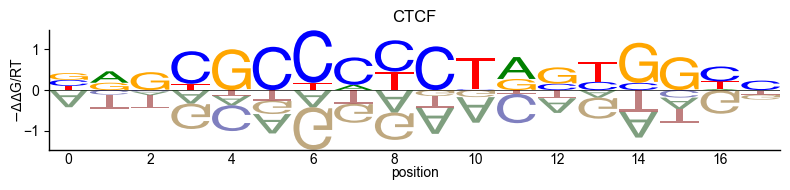

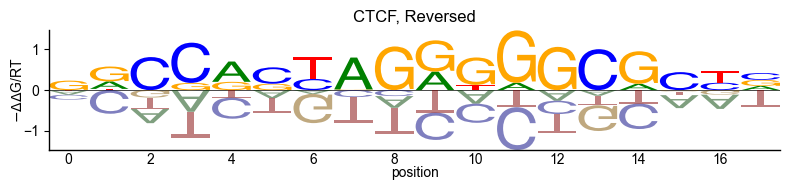

In [12]:
pyprobound.plotting.logo(ctcf_psam)
pyprobound.plotting.logo(ctcf_psam, reverse=True)

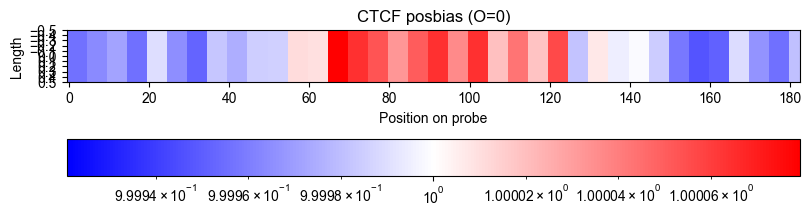

In [13]:
pyprobound.plotting.posbias(mode_ctcf.layers[0])

# Probe enrichment

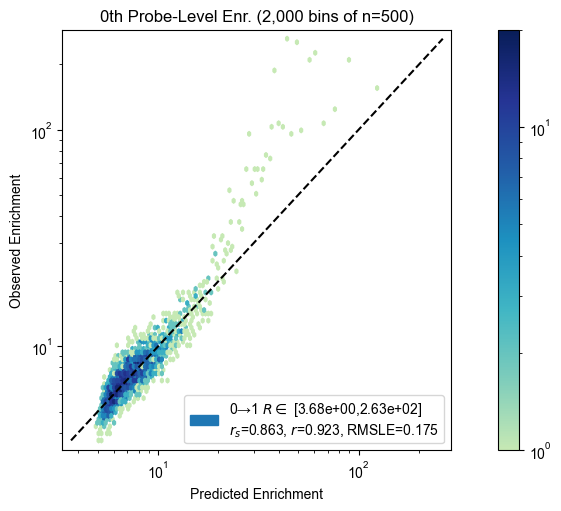

In [14]:
pyprobound.plotting.probe_enrichment(experiment, count_table)

# Mode contribution

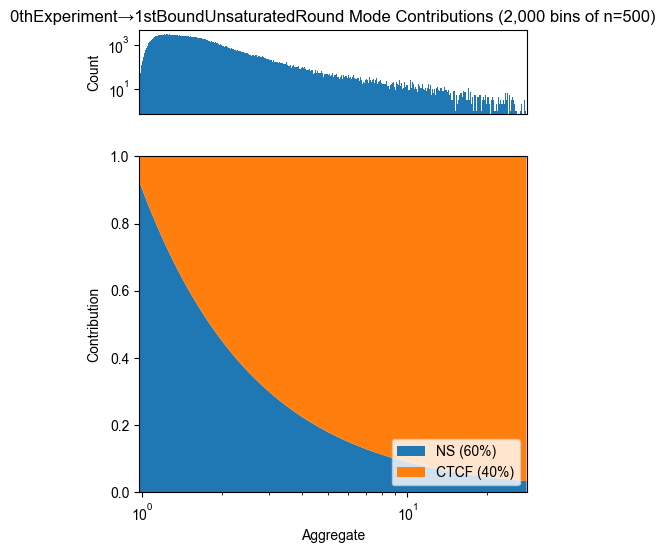

In [15]:
for rnd in experiment.rounds[1:]:
    pyprobound.plotting.contribution(rnd, count_table)